In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

In [2]:
%matplotlib inline

In [3]:
# Configuration for Matplotlib Plots
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams["legend.loc"] = 'center left'

In [4]:
# Here we get the needed pressure data and time per measurement in files
with open('time_per_measurement.txt','r')as f:
  time_per_measurement = float(f.read())

with open('inflation.txt','r')as f:
    string = f.read()

inflation = string.split()
inflation = np.array([float(num) for num in inflation])

with open('deflation.txt','r')as f:
    string = f.read()

deflation = string.split()
deflation = np.array([float(num) for num in deflation])

In [5]:
# Set up x-axis as time
inflation_time = np.arange(0, time_per_measurement * len(inflation), time_per_measurement)

In [6]:
# Set up x-axis as time
deflation_time = np.arange(time_per_measurement * len(inflation), (time_per_measurement * len(inflation) + time_per_measurement * len(deflation)), time_per_measurement)

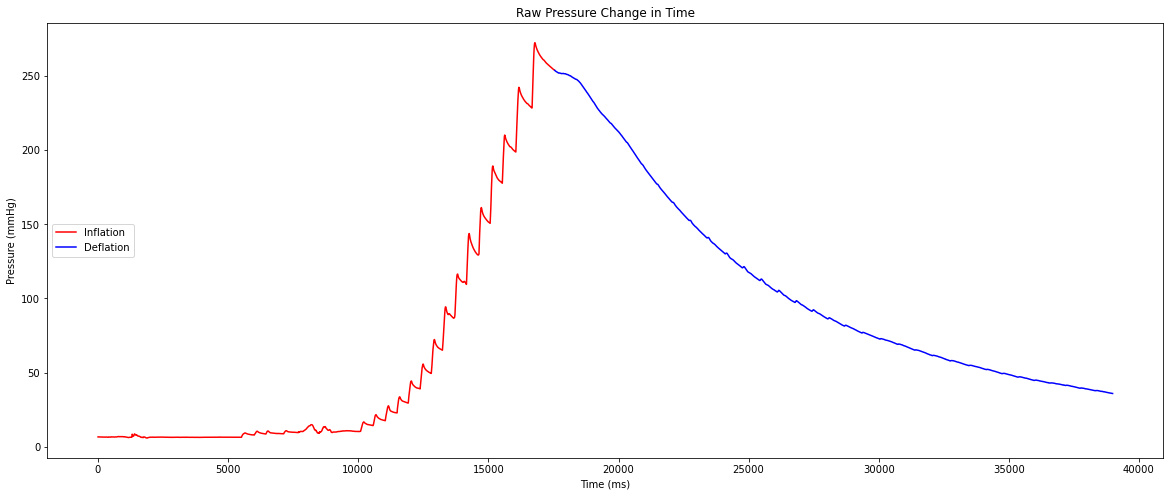

In [7]:
# Plot Entire Raw Pressure Change in Time
plt.plot(inflation_time, inflation, color="red", label="Inflation")
plt.plot(deflation_time, deflation, color="blue", label="Deflation")
plt.xlabel("Time (ms)")
plt.ylabel("Pressure (mmHg)")
plt.title("Raw Pressure Change in Time")
plt.legend()
plt.show()

In [8]:
# This function samples the deflation raw pressure data into a specific range
# Since we only need pressure from 175 - 60
def condense_deflation(array, low, high):
  for i in range(0, len(array)):
    if array[i] <= high:
      array = array[i:]
      break
  for i in range(len(array)-1, -1, -1):
    if array[i] >= low:
      array = array[:i]
      break
  return array

In [9]:
# Get pressure from 175 - 60
useful_deflation = condense_deflation(deflation,60, 175)
# Set up x-axis as time
useful_deflation_time = np.arange(0, time_per_measurement * len(useful_deflation), time_per_measurement)

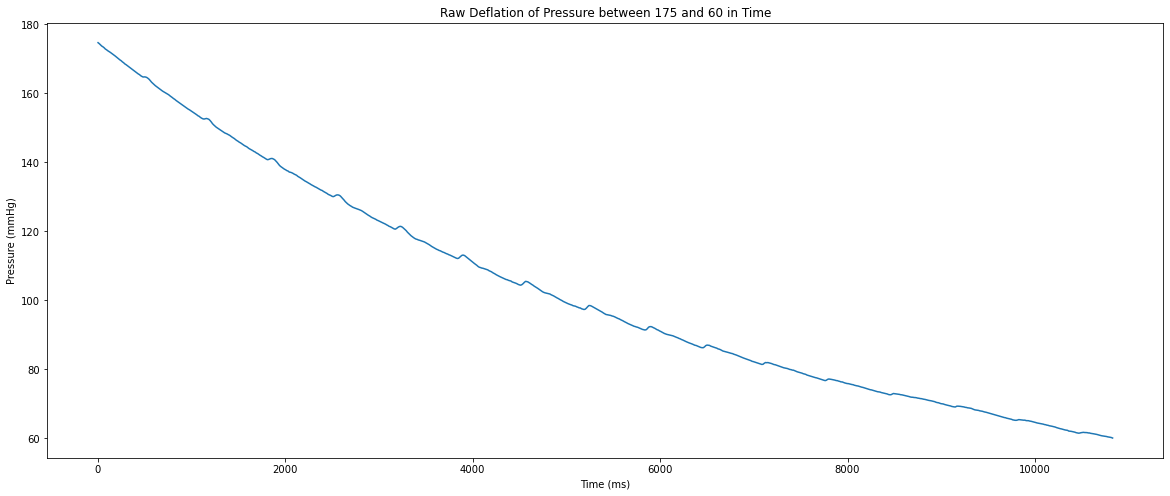

In [10]:
# PlotRaw Deflation of Pressure between 175 and 60 in Time
plt.plot(useful_deflation_time, useful_deflation)
plt.xlabel("Time (ms)")
plt.ylabel("Pressure (mmHg)")
plt.title("Raw Deflation of Pressure between 175 and 60 in Time")
plt.show()

In [11]:
# This is the algorithm for calculating the moving average of a graph
def calculate_moving_average(array, interval):
    i = 0
    window_size = interval
    moving_averages = []
    while i < len(array) - window_size + 1:
        this_window = array[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1  
    return moving_averages

In [12]:
# Find the moving average of the deflation with interval of 50
interval = 50
moving_average = calculate_moving_average(useful_deflation, interval)

In [13]:
# Because we lose 50 data points for the moving average, we sample off 50 data points on our deflation data
# Sample off the first 25 and last 25 points of the deflation data to match the moving average
useful_deflation = useful_deflation[interval // 2:len(useful_deflation) - (interval // 2) + 1]

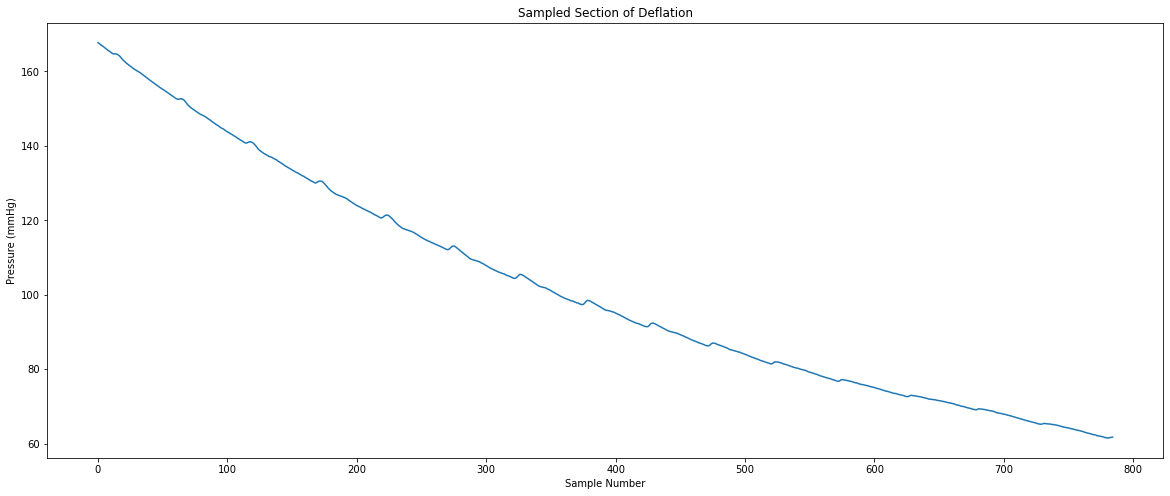

In [14]:
# Plot the Completed Sampled Deflation Data
plt.plot(useful_deflation)
plt.xlabel("Sample Number")
plt.ylabel("Pressure (mmHg)")
plt.title("Sampled Section of Deflation")
plt.show()

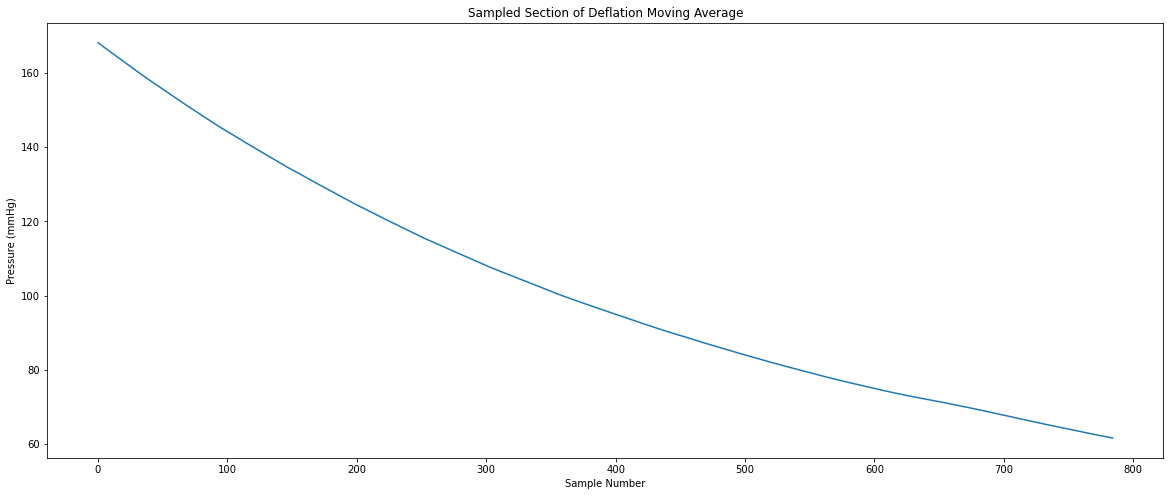

In [15]:
# Plot the Moving Average of the Deflation Data
plt.plot(moving_average)
plt.xlabel("Sample Number")
plt.ylabel("Pressure (mmHg)")
plt.title("Sampled Section of Deflation Moving Average")
plt.show()

In [16]:
# We get the difference between the deflation and moving average to get the oscillations
oscillations = np.abs(np.array(useful_deflation) - np.array(moving_average))

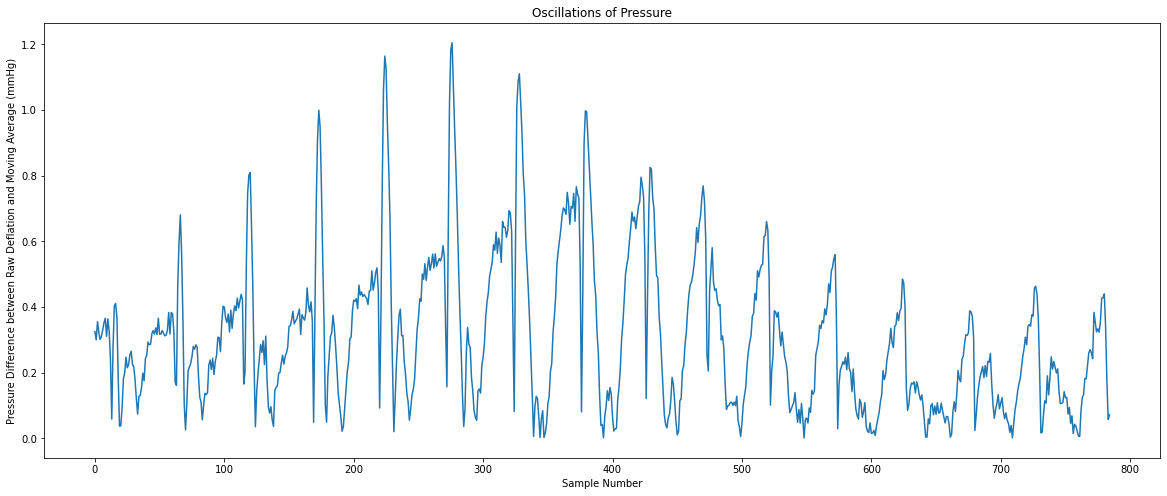

In [17]:
# Plot the Oscillations
plt.plot(oscillations)
plt.xlabel("Sample Number")
plt.ylabel("Pressure Difference between Raw Deflation and Moving Average (mmHg)")
plt.title("Oscillations of Pressure")
plt.show()

In [18]:
# Find the peaks indices of the osillations
# Have parameters width = 3 and distance = 40 to make sure peaks aren't too close
peak_indices, _ = find_peaks(oscillations, width = 3,distance=40)

In [19]:
# Find the actual pressure value of the peaks
peak_pressures = [oscillations[i] for i in peak_indices]

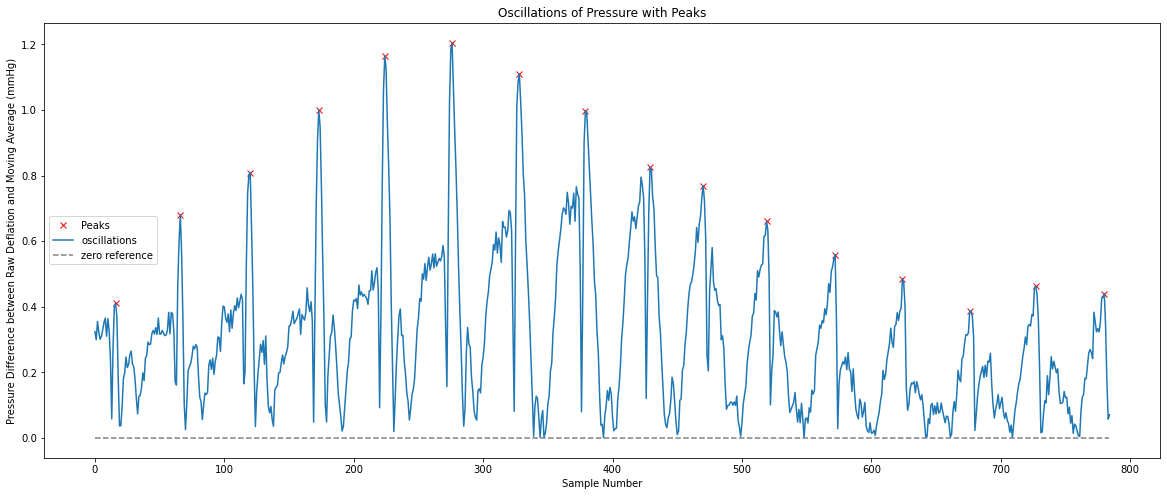

In [20]:
# Plot Oscillations of Pressure with Peaks
plt.plot(peak_indices, peak_pressures, 'x', color="red",label="Peaks")
plt.plot(oscillations,label="oscillations")
plt.plot(np.zeros_like(oscillations), "--", color="gray",label="zero reference")
plt.xlabel("Sample Number")
plt.ylabel("Pressure Difference between Raw Deflation and Moving Average (mmHg)")
plt.title("Oscillations of Pressure with Peaks")
plt.legend()
plt.show()

In [21]:
# Note that the trough of oscillations is zero so the vertical height of the peak is the difference between peak and trough

In [22]:
# Get the index of the maximum peak value in peak_indices array
max_index_pressure = peak_pressures.index(max(peak_pressures))

In [23]:
# This is the index of the maximum peak value in the oscillations array
max_index_oscillation = peak_indices[max_index_pressure]

In [24]:
# This is the actual maximum peak value 
max_pulse = oscillations[max_index_oscillation]

In [25]:
# Systolic Blood Pressure is 50% of the maximum peak value to the left of the max pulse
systolic = max_pulse * 0.5
# Diastolic Blood Pressure is 80% of the maximum peak value to the right of the max pulse
diastolic = max_pulse * 0.8

In [26]:
# The function compare peak values and find the SBP and DBP's value
def find_nearest(array, value):
  array = np.asarray(array)
  idx = (np.abs(array-value)).argmin()
  return array[idx]

In [27]:
# This is the index of the SBP in the oscillations array
sbp_ind = peak_indices[peak_pressures.index(find_nearest(peak_pressures[0:max_index_pressure], systolic))]

In [28]:
# This is the index of the DBP in the oscillations array
dbp_ind = peak_indices[peak_pressures.index(find_nearest(peak_pressures[max_index_pressure:], diastolic))]

In [29]:
# Here we find the max pulse
Max_Pulse = useful_deflation[max_index_oscillation]
print("Pressure for Max Pulse (mmHg) is: {}".format(Max_Pulse)) 

Pressure for Max Pulse (mmHg) is: 112.95


In [30]:
# Here we find the systolic blood pressure
SBP = useful_deflation[sbp_ind]
print("Systolic Blood Pressure (mmHg) is: {}".format(SBP)) 

Systolic Blood Pressure (mmHg) is: 152.44


In [31]:
# Here we find the diaastolic blood pressure
DBP = useful_deflation[dbp_ind]
print("Diastolic Blood Pressure (mmHg) is: {}".format(DBP)) 

Diastolic Blood Pressure (mmHg) is: 98.46


In [32]:
"""
To calculate heart rate, we first find the number of measurements per oscillation
We do that by dividing the total number of measurements with the total number of peaks.
Next we times the number of measurements per oscillation with the time per measurements
to get the time per oscillation. Flip that, and we get the oscillation per second, which 
is the heart rate. 
"""
num_measurements_per_oscillation = len(oscillations)/len(peak_indices)
heart_rate_s = 1/((num_measurements_per_oscillation * time_per_measurement) / 1000)
heart_rate = heart_rate_s * 60
print("Heart Rate (beats/min) is: {}".format(heart_rate))

Heart Rate (beats/min) is: 94.07153356197942
